# # KNN - Nearest Neighbors Using Numpy

In [1]:
from sklearn import datasets
import numpy as np
from collections import Counter
import os

In [3]:
iris  = datasets.load_iris()
data, labels = iris.data, iris.target
iris.keys() # Dataset info

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [4]:
import pandas as pd
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names,index = iris.target)

In [5]:
iris_df[:10]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
0,4.9,3.0,1.4,0.2
0,4.7,3.2,1.3,0.2
0,4.6,3.1,1.5,0.2
0,5.0,3.6,1.4,0.2
0,5.4,3.9,1.7,0.4
0,4.6,3.4,1.4,0.3
0,5.0,3.4,1.5,0.2
0,4.4,2.9,1.4,0.2
0,4.9,3.1,1.5,0.1


In [7]:
np.bincount(labels) # no of classes and samples in each


array([50, 50, 50], dtype=int64)

In [9]:
#random permutation for data split
np.random.seed(345)
indices = np.random.permutation(len(data))

In [11]:
n_training_samples = 85
training_data = data[indices[:n_training_samples]]
training_labels = labels[indices[:n_training_samples]]

testing_data = data[indices[n_training_samples:]]
testing_labels = labels[indices[n_training_samples:]]



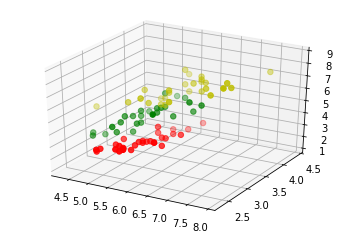

In [13]:
#plotting the data in 3d form
%matplotlib inline 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
X = []
for iclass in range(3):
    X.append([[], [], []])
    for i in range(len(training_data)):
        if training_labels[i] == iclass:
            X[iclass][0].append(training_data[i][0])
            X[iclass][1].append(training_data[i][1])
            X[iclass][2].append(sum(training_data[i][2:])) #last 2 features sum up

colours = ("r", "g", "y")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for iclass in range(3):
       ax.scatter(X[iclass][0], X[iclass][1], X[iclass][2], c=colours[iclass],s=30)
plt.show()

In [14]:
def euclid_distance(instance1, instance2):
    # error if  instance1.shape[0]!= instance2.shape[0]
    # just in case, if the instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    return np.linalg.norm(instance1 - instance2)

In [16]:
def manhattan_distance(instance1,instance2):
    # error if  instance1.shape[0]!= instance2.shape[0]
    dist = 0
    for i in range(len(instance1.shape[0])):
        dist += np.abs(instance1[:,i] - instance2[:,i])
    return dist

In [36]:
def levenshtein_distance(s, t):
    """ 
        iterative_levenshtein(s, t) -> ldist
        ldist is the Levenshtein distance between the strings 
        s and t.
        For all i and j, dist[i,j] will contain the Levenshtein 
        distance between the first i characters of s and the 
        first j characters of t
    """

    rows = len(s)+1
    cols = len(t)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]

    # source prefixes can be transformed into empty strings 
    # by deletions:
    for i in range(1, rows):
        dist[i][0] = i

    # target prefixes can be created from an empty source string
    # by inserting the characters
    for i in range(1, cols):
        dist[0][i] = i
        
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0
            else:
                cost = 1
            dist[row][col] = min(dist[row-1][col] + 1,      # deletion
                                 dist[row][col-1] + 1,      # insertion
                                 dist[row-1][col-1] + cost) # substitution

    #for r in range(rows): print(dist[r])
    
 
    return dist[row][col]
    

In [17]:
def get_k_neighbors(training_set, labels, test_instance, k=3, distance=euclid_distance):
    """
    get_neighors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where 
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = []
    for index in range(len(training_set)):
        dist = distance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors

In [19]:
def vote(neighbors):
    class_counter = Counter()
    for neighbor in neighbors:
        class_counter[neighbor[2]] += 1
    return class_counter.most_common(1)[0][0] #tie case resolve as arbitary

In [21]:
def vote_harmonic_weights(neighbors, all_results=True):
    #The Weighted Nearest Neighbour Classifier , voting based on harmonic series
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        class_counter[neighbors[index][2]] += 1/(index+1)
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if all_results: #return all the negihbors classes
        total = sum(class_counter.values(), 0.0) #just for float conversion
        for key in class_counter:
             class_counter[key] /= total
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [22]:
def vote_distance_weights(neighbors, all_results=True):
    #more better approach using actual distance in account
    class_counter = Counter()
    number_of_neighbors = len(neighbors)
    for index in range(number_of_neighbors):
        dist = neighbors[index][1]
        label = neighbors[index][2]
        class_counter[label] += 1 / (dist**2 + 1)
    labels, votes = zip(*class_counter.most_common())
    #print(labels, votes)
    winner = class_counter.most_common(1)[0][0]
    votes4winner = class_counter.most_common(1)[0][1]
    if all_results:
        total = sum(class_counter.values(), 0.0)
        for key in class_counter:
             class_counter[key] /= total
        return winner, class_counter.most_common()
    else:
        return winner, votes4winner / sum(votes)

In [31]:
#testing the classifier
n_test_samples = data.shape[0]-n_training_samples
predicted_labels = []
ground_truth = []
for i in range(n_test_samples):
    neighbors = get_k_neighbors(training_data, 
                              training_labels, 
                              testing_data[i], 
                              6, 
                              distance=euclid_distance)
    label_dist = vote_distance_weights(neighbors, all_results=False)
    ground_truth.append(testing_labels[i])
    predicted_labels.append(label_dist[0])
    print("Ground Truth Label: ", testing_labels[i], 
          ", result of vote: ", label_dist)

Ground Truth Label:  0 , result of vote:  (0, 1.0)
Ground Truth Label:  2 , result of vote:  (2, 0.8490154592118361)
Ground Truth Label:  1 , result of vote:  (1, 1.0)
Ground Truth Label:  2 , result of vote:  (2, 0.8343228283070399)
Ground Truth Label:  1 , result of vote:  (1, 1.0)
Ground Truth Label:  0 , result of vote:  (0, 1.0)
Ground Truth Label:  1 , result of vote:  (1, 1.0)
Ground Truth Label:  0 , result of vote:  (0, 1.0)
Ground Truth Label:  2 , result of vote:  (2, 1.0)
Ground Truth Label:  1 , result of vote:  (1, 1.0)
Ground Truth Label:  0 , result of vote:  (0, 1.0)
Ground Truth Label:  1 , result of vote:  (1, 1.0)
Ground Truth Label:  0 , result of vote:  (0, 1.0)
Ground Truth Label:  0 , result of vote:  (0, 1.0)
Ground Truth Label:  0 , result of vote:  (0, 1.0)
Ground Truth Label:  2 , result of vote:  (2, 1.0)
Ground Truth Label:  2 , result of vote:  (2, 0.8322905554770411)
Ground Truth Label:  1 , result of vote:  (1, 1.0)
Ground Truth Label:  2 , result of vo

In [32]:
#Calculating Accuracy of classifier
from sklearn.metrics import accuracy_score
accuracy_score(predicted_labels, ground_truth)

0.9846153846153847

### kNN in Linguistics

In [39]:
words = open('words.txt').readlines()
words = [word.strip() for word in words]
truth = ['helpful','kindness','helpless','those','understand','barefoot','liberal']

for word in ["holpful", "kundnoss", "holpposs", "thoes", "innerstand",
             "blagrufoo", "liberdi"]:
    
    neighbors = get_k_neighbors(words, words, word, 3, distance=levenshtein_distance)
    word_dist = vote_distance_weights(neighbors, all_results=False)
    print("Actual: ",Incorrect: ",word," Predicted: ", word_dist[0]," Distance: ",word_dist[1])


Actual:  holpful  Predicted:  helpful  Distance:  0.5555555555555556
Actual:  kundnoss  Predicted:  kindness  Distance:  0.5
Actual:  holpposs  Predicted:  helpless  Distance:  0.3333333333333333
Actual:  thoes  Predicted:  hoes  Distance:  0.3333333333333333
Actual:  innerstand  Predicted:  understand  Distance:  0.5
Actual:  blagrufoo  Predicted:  barefoot  Distance:  0.4333333333333333
Actual:  liberdi  Predicted:  liberal  Distance:  0.4
